#### RNN, LSTM, GRU classification of mouse wheel movement based on Steinmetz `spks` dataset and code from [nma](https://deeplearning.neuromatch.io/projects/Neuroscience/neuro_seq_to_seq.html)

__Note__: You must restart the notebook for training the LSTM and GRU models and each time you rerun a model. This appears to be an issue of the previous model remaining on the GPU after training.

##### Imports

In [1]:
# Imports
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, io, models, ops, transforms, utils
from matplotlib import pyplot as plt

##### Device

In [2]:
# @title Set device (GPU or CPU). Execute `set_device()`

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

##### Set random seed

In [3]:
# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [4]:
SEED = 2021
set_seed(seed=SEED)
device = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


##### Data retrieval

In [5]:
# store the dataset files in the datasets folder
import os, requests

fname = []
ds = "../datasets"

for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile("/".join([ds, fname[j]])):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open("/".join([ds, fname[j]]), "wb") as fid:
          fid.write(r.content)

In [6]:
# data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load("/".join([ds, 'steinmetz_part%d.npz'%j]),
                              allow_pickle=True)['dat']))

##### Select recording 11

In [7]:
# select recording 11
dat = alldat[11]

##### Format dataset
An RNN has specific data requirements fed into the network for training, testing, and prediction. The depth of the network in a time or data series is given by `hidden_size`. In the case of the `spks` dataset this is 250 because one trial lasts for this many samples. These are the 250 sequenced datapoints related to the same mouse event trial from the same probe sensor size of 698 neurons over a time period of 2500ms. Further mouse trials are added in sequence in the dataset, where the training and forward algorithms reset to the start of the RNN. This dataset is then 698 neurons wide with 250 datapoints and 340 trials in length, before being split into train and test sets.

In [8]:
# data are neurons X trials x time samples, but permute to trials X time samples X neurons
x = torch.tensor(dat['spks']).permute(1,2,0)
x = x[:,50:150,:]

# response is -1, 0, 1, but convert to one hot where 2 takes the place of -1 to satisfy torch one hot
dat['response'][dat['response'] == -1] = 2 
y = torch.as_tensor(dat['response']).long()
y = F.one_hot(y)

# split into train (70%), validation(20%) and test(10%) sets using batch size of 34
n_trials = int(x.shape[0])
ntr = int(n_trials * 7 / 10)
nv = int(n_trials * 2 / 10) + ntr

X_train = x[:ntr, :, :].to(device).float()
X_val = x[ntr:nv, :, :].to(device).float()
X_test = x[nv:, :, :].to(device).float()

y_train = y[:ntr].to(device).float()
y_val = y[ntr:nv].to(device).float()
y_test = y[nv:].to(device).float()

In [9]:
print(y[0])
print(x.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

tensor([1, 0, 0])
torch.Size([340, 100, 698])
torch.Size([340, 3])
torch.Size([238, 100, 698])
torch.Size([238, 3])
torch.Size([68, 100, 698])
torch.Size([68, 3])
torch.Size([34, 100, 698])
torch.Size([34, 3])


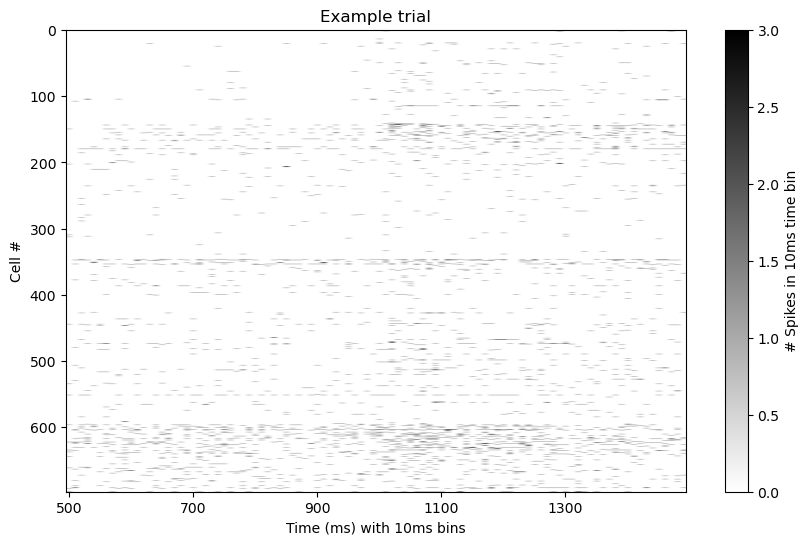

In [10]:
##### Visualise data from one trial
plt.figure(figsize = (10, 6))
plt.imshow(x[0,:,:].T, cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
plt.xticks([0, 20, 40, 60, 80], [500, 700, 900, 1100, 1300]) 
plt.xlabel('Time (ms) with 10ms bins')
plt.ylabel('Cell #')
plt.colorbar(orientation='vertical', label='# Spikes in 10ms time bin')
plt.title('Example trial')
plt.show()

##### Dataloader

In [11]:
# batch_size of 34 used to match number of trials
batch_size = 34

# Create DataLoader for training data
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for validation data
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create DataLoader for test data
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##### Hyperparameters

In [12]:
# number of hidden RNN stages, inputs and outputs
hidden_size = x.shape[1]
input_size = x.shape[2]
output_size = y_train.shape[1]
num_layers = 1
learning_rate = 0.003
number_of_epochs = 10000
RNN_number_of_epochs = 420
LSTM_number_of_epochs = 370
GRU_number_of_epochs = 175

In [13]:
print(hidden_size)
print(input_size)
print(output_size)

100
698
3


##### Define RNN
Since the `hidden_size` is 250 we can expect to see either exploding or vanishing gradients in the RNN. For this case we can't expect the RNN to be able to predict well. But, as Dev did, we can reduce the `hidden_size` by slicing off data which doesn't correspond to wheel movement. 

In [14]:
# chatgpt 3.5 generated code
# RNN Model with Softmax
class RNNWithSoftmax(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNWithSoftmax, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define the RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define the fully connected layer to map RNN output to class labels
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)

        # Use only the last time step's output for classification
        out = self.fc(out[:, -1, :]) 

        # Apply softmax activation
        return nn.functional.softmax(out, dim=1)  

##### Train the RNN: setup

In [15]:
# chatgpt 3.5 generated code
model = RNNWithSoftmax(input_size, hidden_size, output_size, num_layers).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

##### Train the RNN and plot training and validation losses and accuracies
Note that the trained model seems to remain resident on the graphics card unless we restart the notebook.

Epoch [1/420], Training Loss: 1.05597766, Training Accuracy: 0.4454
Epoch [1/420], Validation Loss: 1.06257397, Validation Accuracy: 0.3676
Epoch [2/420], Training Loss: 0.94559876, Training Accuracy: 0.5966
Epoch [2/420], Validation Loss: 0.97351381, Validation Accuracy: 0.6176
Epoch [3/420], Training Loss: 0.80982793, Training Accuracy: 0.8908
Epoch [3/420], Validation Loss: 0.97102642, Validation Accuracy: 0.5441
Epoch [4/420], Training Loss: 0.63517761, Training Accuracy: 0.9832
Epoch [4/420], Validation Loss: 0.86670807, Validation Accuracy: 0.6765
Epoch [5/420], Training Loss: 0.57137954, Training Accuracy: 1.0000
Epoch [5/420], Validation Loss: 0.94492486, Validation Accuracy: 0.5735
Epoch [6/420], Training Loss: 0.55667023, Training Accuracy: 1.0000
Epoch [6/420], Validation Loss: 0.89597318, Validation Accuracy: 0.6471
Epoch [7/420], Training Loss: 0.55355372, Training Accuracy: 1.0000
Epoch [7/420], Validation Loss: 0.91513774, Validation Accuracy: 0.6176
Epoch [8/420], Train

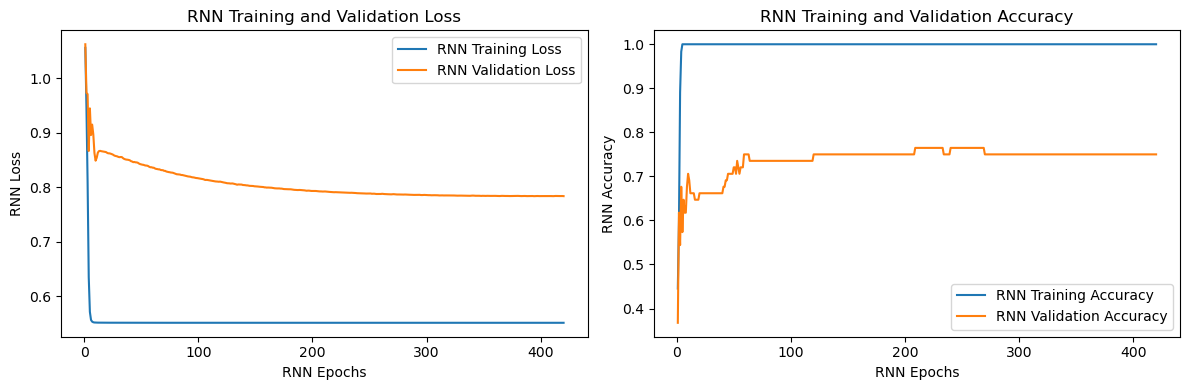

In [16]:
# chatgpt 3.5 generated code
# Training loop
# RNN_total_epochs = number_of_epochs
RNN_total_epochs = RNN_number_of_epochs

# Lists to store training/validation losses and training/validation accuracies
RNN_train_losses = []  
RNN_val_losses = []    
RNN_train_accuracies = []  
RNN_val_accuracies = []    

for epoch in range(RNN_total_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, one_hot_labels in train_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the total training loss for this epoch
        total_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
        total_train += one_hot_labels.size(0)
    
    # Calculate average training loss and accuracy for this epoch
    average_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    # Store training loss and accuracy values
    RNN_train_losses.append(average_train_loss)
    RNN_train_accuracies.append(train_accuracy)
    
    # Print the training loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{RNN_total_epochs}], Training Loss: {average_train_loss:.8f}, Training Accuracy: {train_accuracy:.4f}')
    
    # Validation loop
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, one_hot_labels in val_loader:
            inputs = inputs.to(device)
            one_hot_labels = one_hot_labels.to(device)
            
            # Forward pass (validation)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
            
            # Update the total validation loss for this epoch
            total_val_loss += loss.item()
            
            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
            total_val += one_hot_labels.size(0)
    
    # Calculate average validation loss and accuracy for this epoch
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    # Store validation loss and accuracy values
    RNN_val_losses.append(average_val_loss)
    RNN_val_accuracies.append(val_accuracy)
    
    # Print the validation loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{RNN_total_epochs}], Validation Loss: {average_val_loss:.8f}, Validation Accuracy: {val_accuracy:.4f}')

# Plot the losses and accuracies at the end of all epochs
RNN_x_epochs = list(range(1, RNN_total_epochs + 1))

plt.figure(figsize=(12, 4))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(RNN_x_epochs, RNN_train_losses, label='RNN Training Loss')
plt.plot(RNN_x_epochs, RNN_val_losses, label='RNN Validation Loss')
plt.xlabel('RNN Epochs')
plt.ylabel('RNN Loss')
plt.title('RNN Training and Validation Loss')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(RNN_x_epochs, RNN_train_accuracies, label='RNN Training Accuracy')
plt.plot(RNN_x_epochs, RNN_val_accuracies, label='RNN Validation Accuracy')
plt.xlabel('RNN Epochs')
plt.ylabel('RNN Accuracy')
plt.title('RNN Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

##### Testing 

In [17]:
# chatgpt 3.5 generated code
# Test the model
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for inputs, one_hot_labels in test_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(one_hot_labels, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.6176


##### Analysis
Execution time for 420 epochs on RTX 3090: 6.1s and test accuracy of 0.6176 at 420 epochs.

Still appears to be a case of overfitting due to training loss bottoming out at 0.551 and training accuracy jumping to 100% very early in the epochs. Validation accuracy peaks to 0.7647 and validation loss continues to slowly decrease.

##### Define LSTM

In [14]:
# chatgpt 3.5 generated code
# LSTM Model with Softmax
class LSTMWithSoftmax(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMWithSoftmax, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Use only the last time step's output for classification
        return nn.functional.softmax(out, dim=1)  # Apply softmax activation

##### Train LSTM: setup 

In [15]:
# chatgpt 3.5 generated code
model = LSTMWithSoftmax(input_size, hidden_size, output_size, num_layers).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Train the LSTM and plot training and validation losses and accuracies
Note that the trained model seems to remain resident on the graphics card unless we restart the notebook.

Epoch [1/370], Training Loss: 1.06002525, Training Accuracy: 0.4580
Epoch [1/370], Validation Loss: 1.02713382, Validation Accuracy: 0.3676
Epoch [2/370], Training Loss: 0.95183751, Training Accuracy: 0.6008
Epoch [2/370], Validation Loss: 0.99940088, Validation Accuracy: 0.4559
Epoch [3/370], Training Loss: 0.83808310, Training Accuracy: 0.7269
Epoch [3/370], Validation Loss: 0.87159669, Validation Accuracy: 0.6765
Epoch [4/370], Training Loss: 0.79856108, Training Accuracy: 0.7143
Epoch [4/370], Validation Loss: 1.04886419, Validation Accuracy: 0.3971
Epoch [5/370], Training Loss: 0.79711334, Training Accuracy: 0.8739
Epoch [5/370], Validation Loss: 0.91281730, Validation Accuracy: 0.7500
Epoch [6/370], Training Loss: 0.74848337, Training Accuracy: 0.9286
Epoch [6/370], Validation Loss: 0.90153438, Validation Accuracy: 0.6176
Epoch [7/370], Training Loss: 0.67222907, Training Accuracy: 0.9412
Epoch [7/370], Validation Loss: 0.82162893, Validation Accuracy: 0.7500
Epoch [8/370], Train

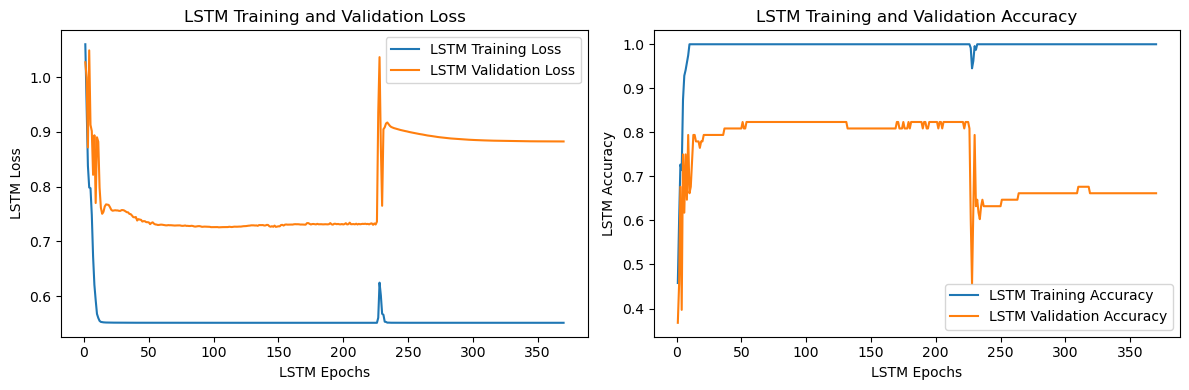

In [16]:
# chatgpt 3.5 generated code (this code is a copy of the RNN code)
# Training loop
# LSTM_total_epochs = number_of_epochs
LSTM_total_epochs = LSTM_number_of_epochs

# Lists to store training/validation losses and training/validation accuracies
LSTM_train_losses = []  
LSTM_val_losses = []    
LSTM_train_accuracies = []  
LSTM_val_accuracies = []    

for epoch in range(LSTM_total_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, one_hot_labels in train_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the total training loss for this epoch
        total_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
        total_train += one_hot_labels.size(0)
    
    # Calculate average training loss and accuracy for this epoch
    average_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    # Store training loss and accuracy values
    LSTM_train_losses.append(average_train_loss)
    LSTM_train_accuracies.append(train_accuracy)
    
    # Print the training loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{LSTM_total_epochs}], Training Loss: {average_train_loss:.8f}, Training Accuracy: {train_accuracy:.4f}')
    
    # Validation loop
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, one_hot_labels in val_loader:
            inputs = inputs.to(device)
            one_hot_labels = one_hot_labels.to(device)
            
            # Forward pass (validation)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
            
            # Update the total validation loss for this epoch
            total_val_loss += loss.item()
            
            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
            total_val += one_hot_labels.size(0)
    
    # Calculate average validation loss and accuracy for this epoch
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    # Store validation loss and accuracy values
    LSTM_val_losses.append(average_val_loss)
    LSTM_val_accuracies.append(val_accuracy)
    
    # Print the validation loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{LSTM_total_epochs}], Validation Loss: {average_val_loss:.8f}, Validation Accuracy: {val_accuracy:.4f}')

# Plot the losses and accuracies at the end of all epochs
LSTM_x_epochs = list(range(1, LSTM_total_epochs + 1))

plt.figure(figsize=(12, 4))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(LSTM_x_epochs, LSTM_train_losses, label='LSTM Training Loss')
plt.plot(LSTM_x_epochs, LSTM_val_losses, label='LSTM Validation Loss')
plt.xlabel('LSTM Epochs')
plt.ylabel('LSTM Loss')
plt.title('LSTM Training and Validation Loss')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(LSTM_x_epochs, LSTM_train_accuracies, label='LSTM Training Accuracy')
plt.plot(LSTM_x_epochs, LSTM_val_accuracies, label='LSTM Validation Accuracy')
plt.xlabel('LSTM Epochs')
plt.ylabel('LSTM Accuracy')
plt.title('LSTM Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

##### Testing 

In [17]:
# chatgpt 3.5 generated code
# Test the model
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for inputs, one_hot_labels in test_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(one_hot_labels, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.4412


##### Analysis LSTM
Execution time for 370 epochs on RTX 3090: 6.8s and test accuracy of 0.4412 at 370 epochs.

Looks like training should've ended by 100 epochs.

##### Define GRU

In [14]:
# chatgpt 3.5 generated code
# GRU Model with Softmax
class GRUWithSoftmax(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUWithSoftmax, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])  # Use only the last time step's output for classification
        return nn.functional.softmax(out, dim=1)  # Apply softmax activation

##### Train GRU: setup 

In [15]:
# chatgpt 3.5 generated code
model = GRUWithSoftmax(input_size, hidden_size, output_size, num_layers).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Train the GRU and plot training and validation losses and accuracies
Note that the trained model seems to remain resident on the graphics card unless we restart the notebook.

Epoch [1/175], Training Loss: 1.06487191, Training Accuracy: 0.4160
Epoch [1/175], Validation Loss: 1.04531300, Validation Accuracy: 0.3676
Epoch [2/175], Training Loss: 0.98955949, Training Accuracy: 0.4622
Epoch [2/175], Validation Loss: 0.99337682, Validation Accuracy: 0.4706
Epoch [3/175], Training Loss: 0.90022551, Training Accuracy: 0.7605
Epoch [3/175], Validation Loss: 0.95405197, Validation Accuracy: 0.5735
Epoch [4/175], Training Loss: 0.76882503, Training Accuracy: 0.8992
Epoch [4/175], Validation Loss: 0.82522514, Validation Accuracy: 0.7941
Epoch [5/175], Training Loss: 0.66112555, Training Accuracy: 0.9202
Epoch [5/175], Validation Loss: 0.79935202, Validation Accuracy: 0.7647
Epoch [6/175], Training Loss: 0.60162450, Training Accuracy: 0.9706
Epoch [6/175], Validation Loss: 0.82508758, Validation Accuracy: 0.7500
Epoch [7/175], Training Loss: 0.57382257, Training Accuracy: 0.9958
Epoch [7/175], Validation Loss: 0.83040369, Validation Accuracy: 0.7206
Epoch [8/175], Train

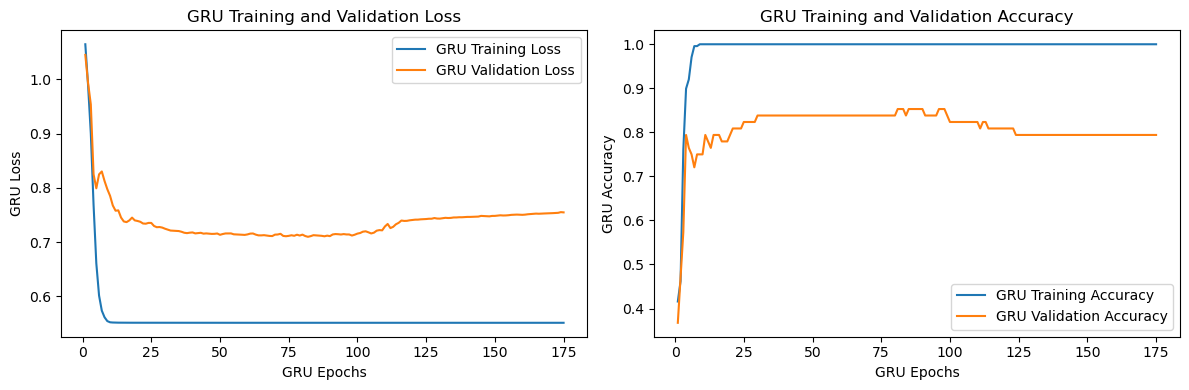

In [16]:
# chatgpt 3.5 generated code (this code is a copy of the RNN code)
# Training loop
# GRU_total_epochs = number_of_epochs
GRU_total_epochs = GRU_number_of_epochs

# Lists to store training/validation losses and training/validation accuracies
GRU_train_losses = []  
GRU_val_losses = []    
GRU_train_accuracies = []  
GRU_val_accuracies = []    

for epoch in range(GRU_total_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, one_hot_labels in train_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the total training loss for this epoch
        total_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
        total_train += one_hot_labels.size(0)
    
    # Calculate average training loss and accuracy for this epoch
    average_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    # Store training loss and accuracy values
    GRU_train_losses.append(average_train_loss)
    GRU_train_accuracies.append(train_accuracy)
    
    # Print the training loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{GRU_total_epochs}], Training Loss: {average_train_loss:.8f}, Training Accuracy: {train_accuracy:.4f}')
    
    # Validation loop
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, one_hot_labels in val_loader:
            inputs = inputs.to(device)
            one_hot_labels = one_hot_labels.to(device)
            
            # Forward pass (validation)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
            
            # Update the total validation loss for this epoch
            total_val_loss += loss.item()
            
            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
            total_val += one_hot_labels.size(0)
    
    # Calculate average validation loss and accuracy for this epoch
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    # Store validation loss and accuracy values
    GRU_val_losses.append(average_val_loss)
    GRU_val_accuracies.append(val_accuracy)
    
    # Print the validation loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{GRU_total_epochs}], Validation Loss: {average_val_loss:.8f}, Validation Accuracy: {val_accuracy:.4f}')

# Plot the losses and accuracies at the end of all epochs
GRU_x_epochs = list(range(1, GRU_total_epochs + 1))

plt.figure(figsize=(12, 4))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(GRU_x_epochs, GRU_train_losses, label='GRU Training Loss')
plt.plot(GRU_x_epochs, GRU_val_losses, label='GRU Validation Loss')
plt.xlabel('GRU Epochs')
plt.ylabel('GRU Loss')
plt.title('GRU Training and Validation Loss')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(GRU_x_epochs, GRU_train_accuracies, label='GRU Training Accuracy')
plt.plot(GRU_x_epochs, GRU_val_accuracies, label='GRU Validation Accuracy')
plt.xlabel('GRU Epochs')
plt.ylabel('GRU Accuracy')
plt.title('GRU Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

##### Testing

In [17]:
# chatgpt 3.5 generated code
# Test the model
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for inputs, one_hot_labels in test_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(one_hot_labels, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.6765


##### Analysis GRU
Execution time for 175 epochs on RTX 3090: 3.1s and test accuracy of 0.6765 at 175 epochs.

Looks like training should've ended at 75 epochs. Again this appears to be a case of overfitting due to training loss bottoming out near 0.551 and training accuracy jumping to 100% very early in the epochs. Validation accuracy peaks to 0.8382 very early at 75 epochs and validation loss continues to increase. 

The test accuracy is better than the RNN and should improve by stopping at 75 epochs.

Takeaway: rerun for the new epoch stopping values and compare. So far the GRU is in the lead.